In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import probplot

import warnings

warnings.filterwarnings('ignore')

In [2]:
train=pd.read_csv('/kaggle/input/../input/tabular-playground-series-mar-2021/train.csv')
test=pd.read_csv('/kaggle/input/../input/tabular-playground-series-mar-2021/test.csv')
submit=pd.read_csv('/kaggle/input/../input/tabular-playground-series-mar-2021/sample_submission.csv')

In [3]:
def datainfo(df):
    return pd.DataFrame([(col,df[col].nunique(),df[col].dtype,df[col].isna().sum(),
                         df[col].unique()[:5]) for col in df.columns],
                        columns=['name','nunique','dtype','missing','value:5'])
datainfo(train)

,name,nunique,dtype,missing,value:5
0,id,300000,int64,0,"[0, 1, 2, 3, 4]"
1,cat0,2,object,0,"[A, B]"
2,cat1,15,object,0,"[I, K, A, F, L]"
3,cat2,19,object,0,"[A, G, C, O, D]"
4,cat3,13,object,0,"[B, A, C, D, G]"
5,cat4,20,object,0,"[B, E, H, I, D]"
6,cat5,84,object,0,"[BI, AB, BU, M, T]"
7,cat6,16,object,0,"[A, K, C, I, G]"
8,cat7,51,object,0,"[S, W, E, Y, G]"
9,cat8,61,object,0,"[Q, AD, BM, Y, AG]"


In [4]:
cat_cols=[col for col in train.columns if 'cat' in col]
num_cols=[col for col in train.columns if 'cont' in col]

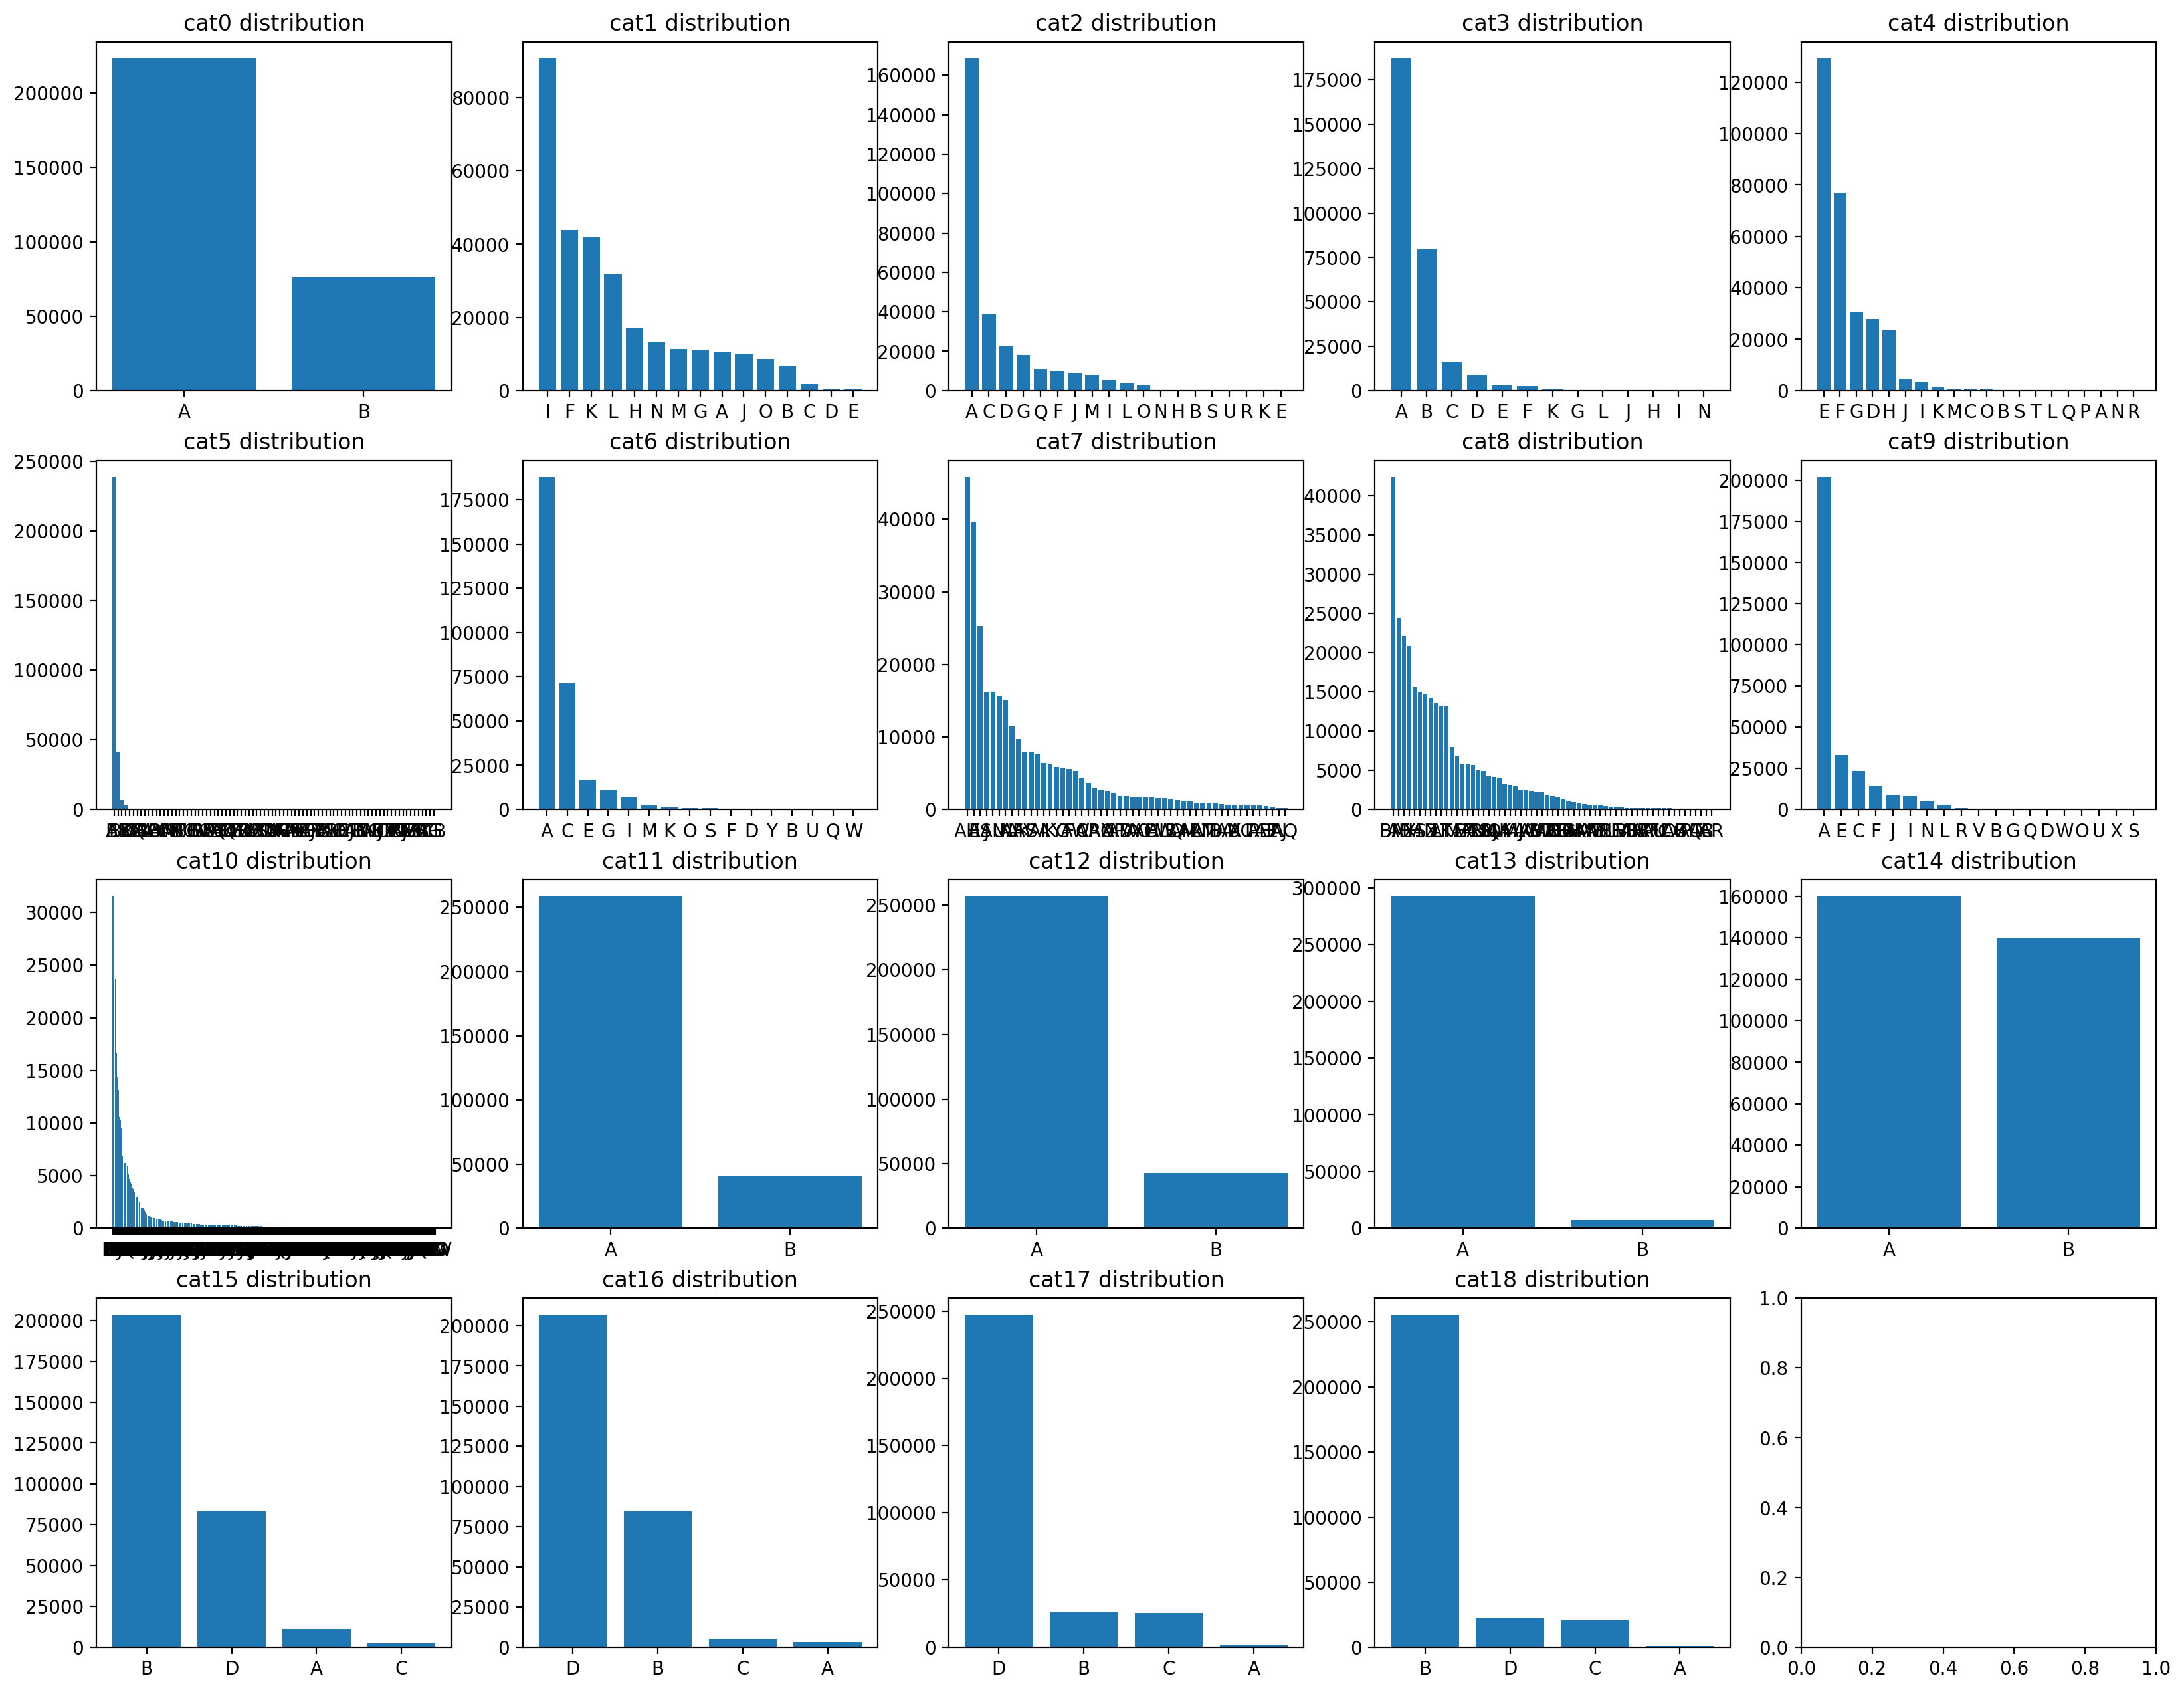

In [5]:
fig,ax=plt.subplots(4,5,figsize=(20,16),dpi=200)

for idx,col in enumerate(cat_cols):
    temp=train[col].value_counts()
    
    ax[idx//5][idx%5].bar(x=temp.index,height=temp)
    ax[idx//5][idx%5].set_title(f'{col} distribution')
plt.show()

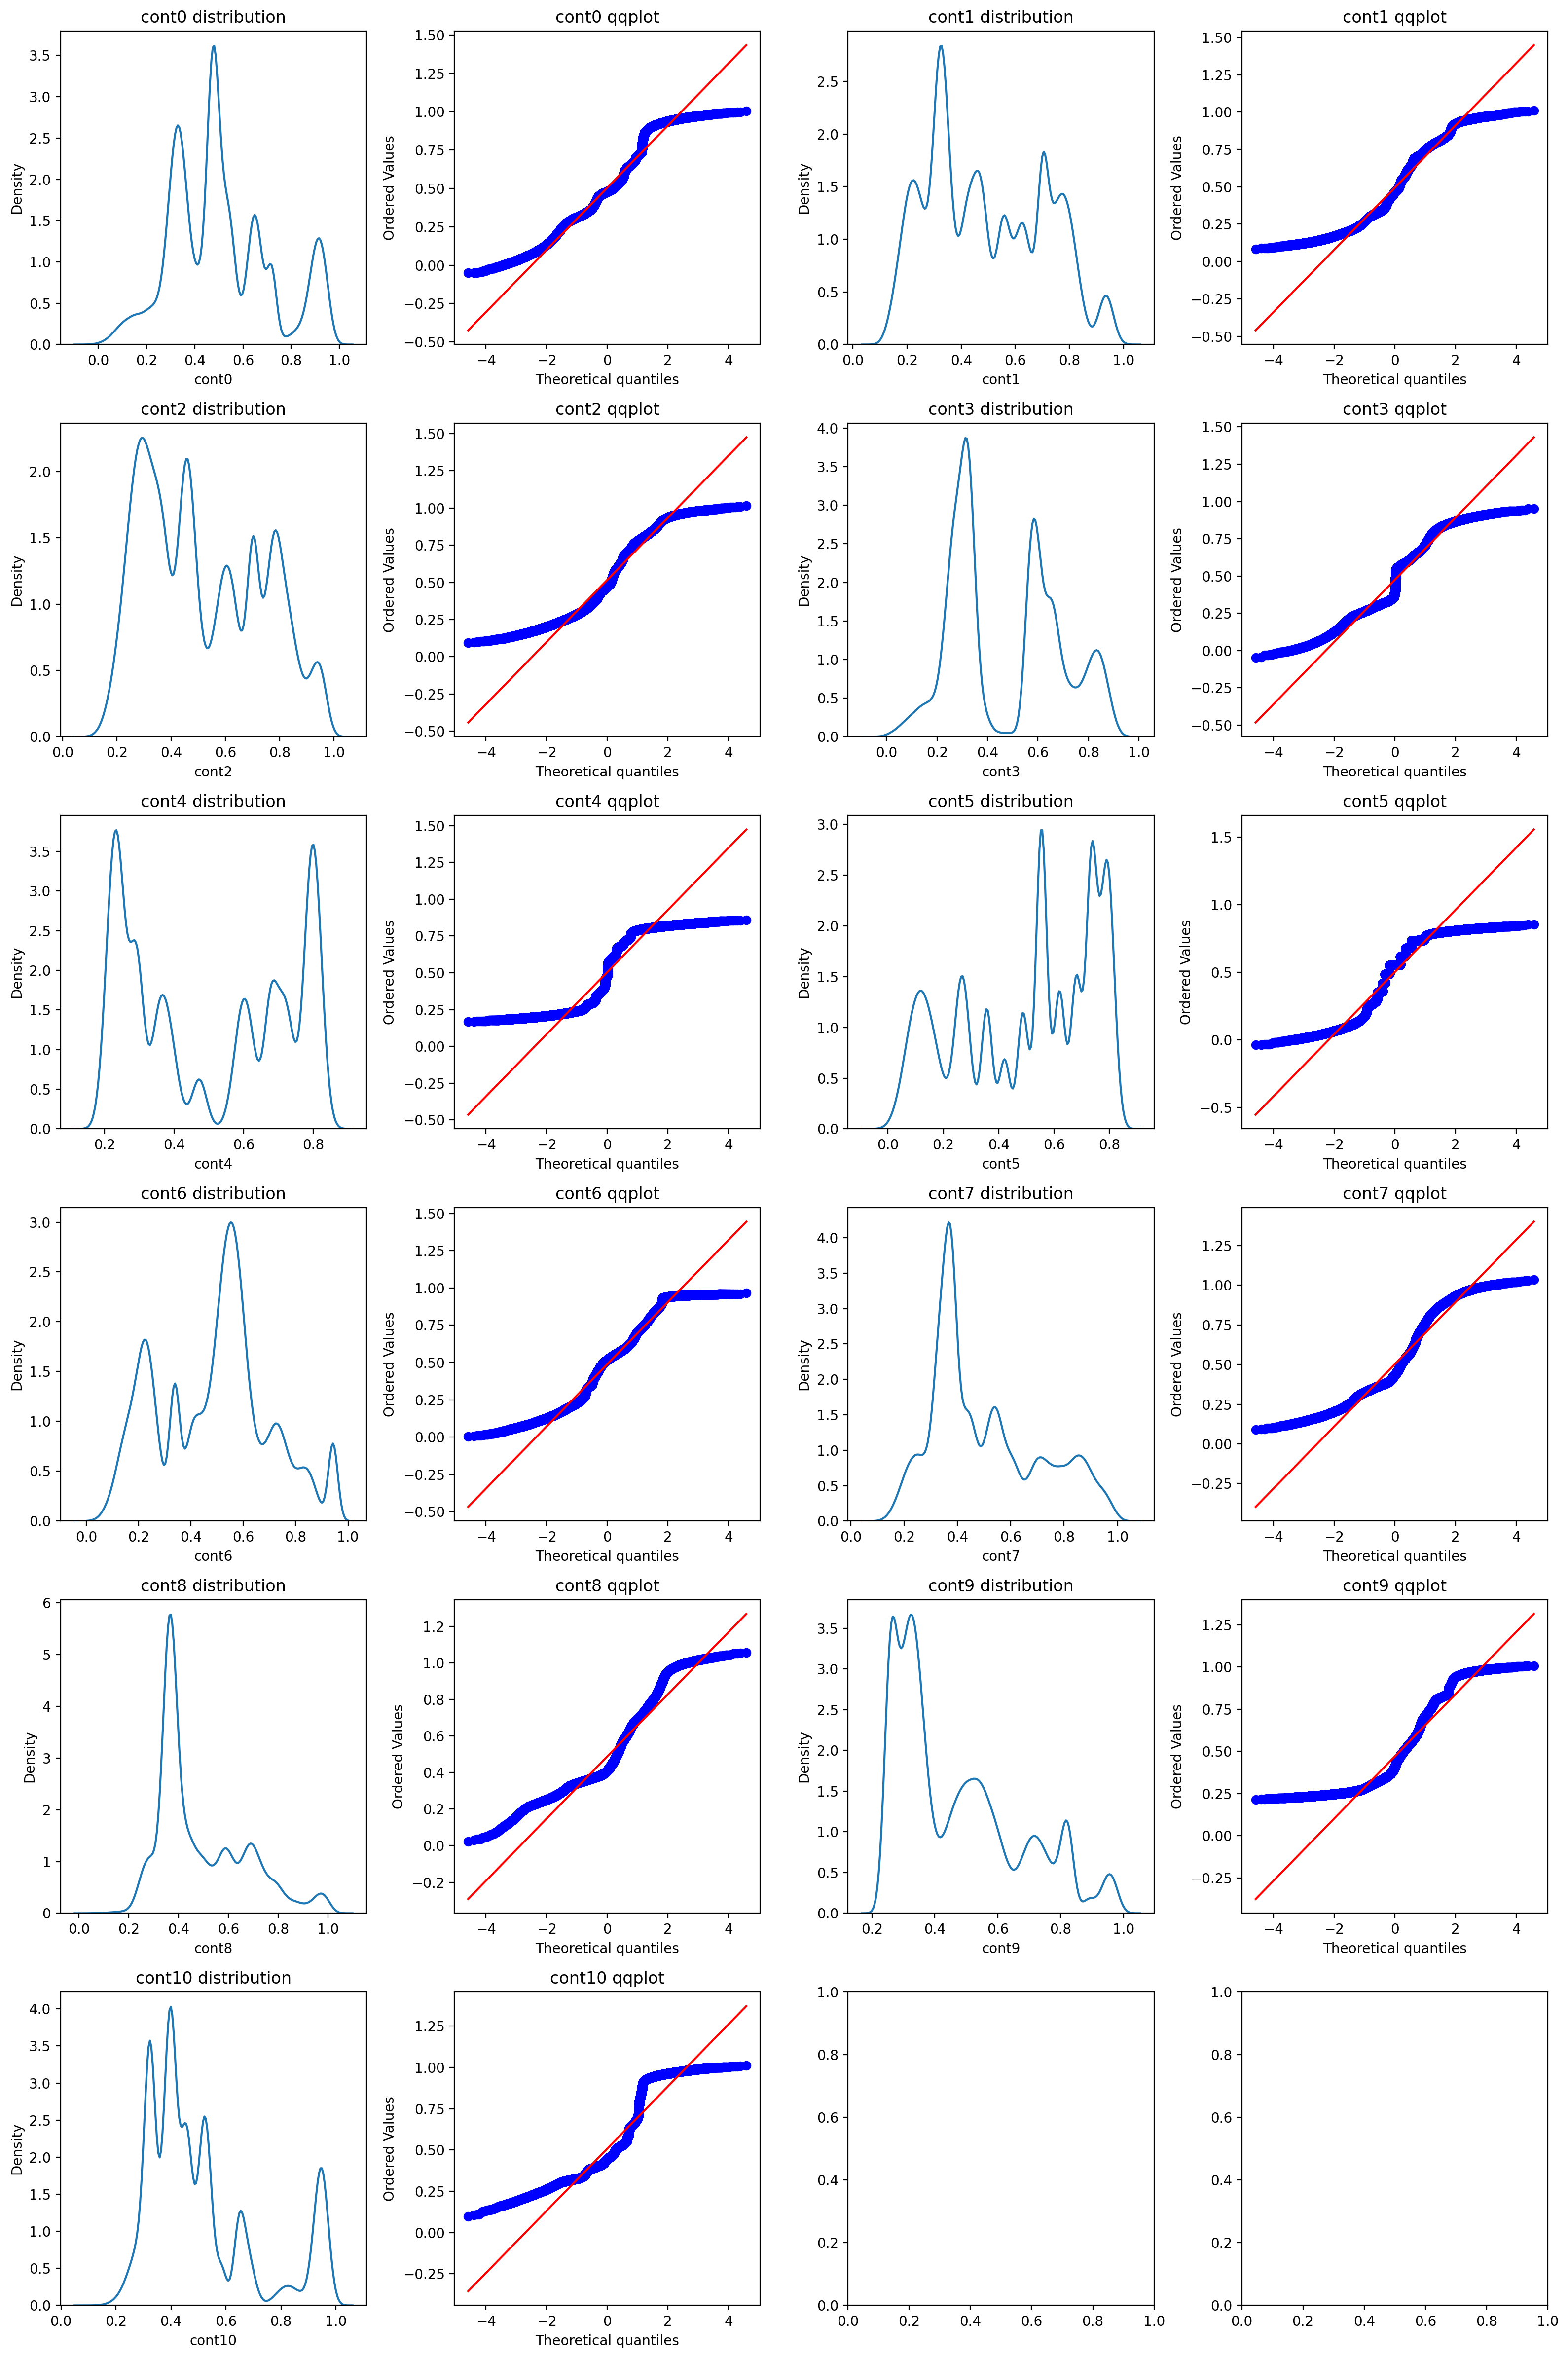

In [6]:
fig,ax=plt.subplots(6,4,figsize=(16,24),dpi=200)
idx=0

for col in num_cols:
    temp=train[col]
    
    sns.kdeplot(temp,ax=ax[idx//4][idx%4])
    ax[idx//4][idx%4].set_title(f'{col} distribution')
    
    idx+=1
    
    probplot(temp,plot=ax[idx//4][idx%4])
    ax[idx//4][idx%4].set_title(f'{col} qqplot')
    
    idx+=1
    
plt.tight_layout()
plt.show()

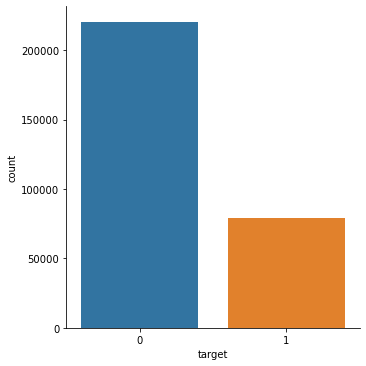

In [7]:
sns.catplot(x='target',data=train,kind='count');

# model - benchmark

In [8]:
import category_encoders as ce 

for col in cat_cols:
    # 새로 정의 안하면 계속 누적되나보다.
    oe=ce.OrdinalEncoder()
    oe.fit(train[col])
    train[col]=oe.transform(train[col])
    test[col]=oe.transform(test[col])

In [9]:
from sklearn.model_selection import train_test_split

y=train['target']
X=train.drop(['id','target'],axis=1)

X_tr,X_val,y_tr,y_val=train_test_split(X,y,test_size=0.2,random_state=71)

In [10]:
import xgboost as xgb

base_params={
    'use_label_encoder':False,
    'random_state':71
}

model=xgb.XGBClassifier(**base_params)

model.fit(X_tr,y_tr,
          eval_set=[(X_tr,y_tr),(X_val,y_val)],
          eval_metric='logloss',
          verbose=True)

[0]	validation_0-logloss:0.56157	validation_1-logloss:0.56339
[1]	validation_0-logloss:0.48959	validation_1-logloss:0.49276
[2]	validation_0-logloss:0.44666	validation_1-logloss:0.45083
[3]	validation_0-logloss:0.41916	validation_1-logloss:0.42431
[4]	validation_0-logloss:0.40119	validation_1-logloss:0.40714
[5]	validation_0-logloss:0.38884	validation_1-logloss:0.39547
[6]	validation_0-logloss:0.38081	validation_1-logloss:0.38819
[7]	validation_0-logloss:0.37499	validation_1-logloss:0.38301
[8]	validation_0-logloss:0.37015	validation_1-logloss:0.37872
[9]	validation_0-logloss:0.36677	validation_1-logloss:0.37582
[10]	validation_0-logloss:0.36404	validation_1-logloss:0.37364
[11]	validation_0-logloss:0.36207	validation_1-logloss:0.37211
[12]	validation_0-logloss:0.36008	validation_1-logloss:0.37044
[13]	validation_0-logloss:0.35846	validation_1-logloss:0.36915
[14]	validation_0-logloss:0.35608	validation_1-logloss:0.36716
[15]	validation_0-logloss:0.35458	validation_1-logloss:0.36604
[1

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=71,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [11]:
from sklearn.metrics import log_loss

pred=model.predict(X_val)
print(f'score : {log_loss(pred,y_val)}')

score : 5.330565582787262


In [12]:
test=test.drop('id',axis=1)

pred=model.predict(test)

submit['target']=pred
submit.head()

,id,target
0,5,0
1,6,0
2,8,0
3,9,0
4,11,0


In [13]:
submit.to_csv('submission.csv',index=False)